In [1]:
import pandas as pd
# from pandas import ExcelWriter
# from pandas import ExcelFile
import numpy as np
import datetime as dt
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import unicodedata
import re 

In [ ]:
diretorio = "C:\\Users\\Weisner Resende\\Documents\\Mega Estudos\\UNB - Receita\\"  #Notebook

In [2]:
diretorio = "D:\\Weisner\\Documentos\\MEGA Estudos\\UNB - Receita\\"  #Desktop

In [3]:
arquivo   = "Base_1milhão.xlsx"
stopwords = set(stopwords.words('portuguese') )

In [4]:
listaRetiraInicio = ['BB','Z ', 'MC ']
listaRetiraFim    = [' CC']
listaCaracteresIndesejados = ["	", # tabulação
                              "*","#","|"]

In [5]:
# retira stop words do nome dos usuários reais
def limpaTexto( entrada ):
    
    # PROBLEMA: TEM QUE VERIFICAR A LISTA DE STOPWORDS PARA QUE ELA 
    # NÃO RETIRE DESCRIÇÃO VÁLIDA DE PRODUTOS.
    # retira stopwords
    entrada = str(entrada)
    entrada = entrada.split(" ")
    saida = ""
    for item in entrada:
        if item.lower() not in stopwords:
            saida = saida + item + " "
    
    # retira acentos
    aux   = str(saida)
    nfkd  = unicodedata.normalize('NFKD', aux)
    saida = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    
    # transforma em maiúsculo, retira espaços dos extremos (TRIM), 
    saida = saida.upper().strip()
    
    # retira caracteres indesejados --> cuidado para não unir palavras separadas pelo caracter
    for item in listaCaracteresIndesejados:
        saida = saida.replace(item,"")    
    
    # retira espaços duplos dentro da string
    saida = saida.replace("  "," ")
    while saida.find('  ') != -1:
        saida = saida.replace("  "," ")
              
    # retira inicios de strings que constam na lista listaRetiraInicio
    for item in listaRetiraInicio:
        # retira espaços duplos dentro do item, pois o mesmo já foi feito no texto a pesquisar
        item = item.replace("  "," ")
        while item.find('  ') != -1:
            item = item.replace("  "," ")
            
        if saida.startswith(item):
            tamanhoItem  = len(item)
            tamanhoSaida = len(saida)            
            if tamanhoSaida > tamanhoItem:
                saida = saida[tamanhoItem:]
    
    # retira fins de strings que constam na lista listaRetiraFim
    for item in listaRetiraFim:
        # retira espaços duplos dentro do item, pois o mesmo já foi feito no texto a pesquisar
        item = item.replace("  "," ")
        while item.find('  ') != -1:
            item = item.replace("  "," ")        
        
        if saida.endswith(item):
            tamanhoItem  = len(item)
            tamanhoSaida = len(saida)
            if tamanhoSaida > tamanhoItem:
                saida = saida[:tamanhoSaida-tamanhoItem]        


    # retira espaços duplos dentro da string. Necessário pois pode ter sobrado 
    # espaço depois das alterações
    saida = saida.strip()
        
    return saida 

In [ ]:
## Lê os dados do arquivo

In [6]:
df_backup = pd.read_excel(diretorio + arquivo, sheet_name='Catalogo1')

In [115]:
# Como a leitura do arquivo demora, para economizar tempo, é deixado um DF de backup com dados lidos.
df = df_backup.copy()

In [116]:
## Exibe tamanho e amostra 

In [117]:
df.shape

(1015381, 10)

In [118]:
df.head(5)

,Nome,Desc_Catalogo,NCM_NFe,Desc_Anexo_IV,NCM_Calc_Prov,Cor_NCM_Calc,NCM_Calc,Item_Anexo_IV,Prod_ST,Prod_FCP
0,Martins,*CACHACA SAO FRANCISCO 12X970M,22084000,aguardente,220840001.0,0.0,220840001.0,30.0,sim,sim
1,Martins,*CACHACA YPIOCA EMP.OURO 965ML,22084000,aguardente,220840001.0,0.0,220840001.0,30.0,sim,sim
2,Martins,*CACHACA YPIOCA OURO 965ML,22084000,aguardente,220840001.0,0.0,220840001.0,30.0,sim,sim
3,Martins,*CACHACA YPIOCA PRATA 965ML,22084000,aguardente,220840001.0,0.0,220840001.0,30.0,sim,sim
4,Trilix,| BB CACHACA SAGATIBA PURA 700 ML (12) - GF,22040000,aguardente,NaN,220840001.0,220840001.0,30.0,sim,sim


In [119]:
# Cria coluna categorias e elimina colunas desnecessárias

In [120]:
df['Categoria'] = df['Item_Anexo_IV'].astype(str) + df['Prod_ST'].astype(str) + df['Prod_FCP'].astype(str)

In [121]:
df.drop([ 'NCM_NFe', 'Desc_Anexo_IV', 'NCM_Calc_Prov', 'Cor_NCM_Calc', 'NCM_Calc', 'Item_Anexo_IV', 
         'Prod_ST','Prod_FCP'], axis=1, inplace=True)

In [122]:
df.head(5)

,Nome,Desc_Catalogo,Categoria
0,Martins,*CACHACA SAO FRANCISCO 12X970M,30.0simsim
1,Martins,*CACHACA YPIOCA EMP.OURO 965ML,30.0simsim
2,Martins,*CACHACA YPIOCA OURO 965ML,30.0simsim
3,Martins,*CACHACA YPIOCA PRATA 965ML,30.0simsim
4,Trilix,| BB CACHACA SAGATIBA PURA 700 ML (12) - GF,30.0simsim


In [ ]:
# Retira cetegorias indesejadas

In [123]:
# Retira as categorias ['nannãonão', 'nannãosim','nansimnão', 'nansimsim']
categoriasIndesejadas = ['nannãonão', 'nannãosim','nansimnão', 'nansimsim']
df = df[ ~df["Categoria"].isin( categoriasIndesejadas ) ]
del categoriasIndesejadas

In [124]:
df.head(5)

,Nome,Desc_Catalogo,Categoria
0,Martins,*CACHACA SAO FRANCISCO 12X970M,30.0simsim
1,Martins,*CACHACA YPIOCA EMP.OURO 965ML,30.0simsim
2,Martins,*CACHACA YPIOCA OURO 965ML,30.0simsim
3,Martins,*CACHACA YPIOCA PRATA 965ML,30.0simsim
4,Trilix,| BB CACHACA SAGATIBA PURA 700 ML (12) - GF,30.0simsim


In [ ]:
# Faz primeiro tratamento do texto. Lista de palavras indesejadas e obtidas manualmente ainda permanecem.

In [125]:
# Insere coluna "NovaDescricao" com as descrições tratadas 
novadescricao = map( limpaTexto, df['Desc_Catalogo'] ) 
df.insert( loc = 2, column = "NovaDescricao", value = list(novadescricao))#, allow_duplicates = False)
df.drop(['Desc_Catalogo'], axis=1, inplace=True)
del novadescricao

In [126]:
# Apaga linhas cuja coluna 'NovaDescricao' esteja em branco
antes = df.shape[0]
df['NovaDescricao'].dropna( axis=0, inplace=True )  
print( 'Eliminados', antes - df.shape[0], 'registros')
del antes

Eliminados 0 registros


In [127]:
# Trata coluna "Remetente"
novo_remetente = map( limpaTexto, df['Nome'] ) 
del df['Nome']
df.insert( loc = 0, column = "Remetente", value = list(novo_remetente))#, allow_duplicates = False)
del novo_remetente

In [128]:
##  Elimina linhas inconsistentes, repetidas. Mantém a primeira delas
antes = df.shape[0]
df.drop_duplicates( subset = ["NovaDescricao"], inplace = True) 
print( 'Eliminados', antes - df.shape[0], 'registros')
del antes

Eliminados 132280 registros


In [129]:
df.head(5)

,Remetente,NovaDescricao,Categoria
0,MARTINS,CACHACA SAO FRANCISCO 12X970M,30.0simsim
1,MARTINS,CACHACA YPIOCA EMP.OURO,30.0simsim
2,MARTINS,CACHACA YPIOCA OURO,30.0simsim
3,MARTINS,CACHACA YPIOCA PRATA,30.0simsim
4,TRILIX,BB CACHACA SAGATIBA PURA (12) GF,30.0simsim


In [130]:
df['NovaDescricao'].is_unique

True

In [131]:
# retorna o numero de elementos da série, incluindo os registros nulos
df['NovaDescricao'].shape

(598061,)

In [132]:
# retorna o número de elementos da série, EXcluindo os registros nulos
df['NovaDescricao'].count() 

598061

In [133]:
# Com o (), retorna a contagem de cada elemento (frequência). Vide mais opções dentro do ()
df['NovaDescricao'].value_counts().head(10)

TRAT FRUCTIS CACHOS PODER                            1
CUBA INOX N2 56X34X17MM ACETIN 3.1/2                 1
PARAF SEX ACO8.8 MA 08(1,25)X RP C/0100              1
MOLHO POUCH MADEIRA DAJUDA 36X340GR                  1
VINAGRE CASTELO ALC.HORT COLOR                       1
TIARA PRINCESA                                       1
SAX TOMADA DUPLA 2P+T P.BRAS.10A 675062.             1
GRANULADO CROCANTE COLORIDO MIL CORES 1,01           1
SH.NIELY GOLD MATIZADOR                              1
PISO ITAGRES 51X103 POL. RET ETRUSCAN ROSE HD A/2    1
Name: NovaDescricao, dtype: int64

In [ ]:
# Mostra distribuição das categorias

In [134]:
df['Categoria'].value_counts()

41.0simnão    134071
40.0simnão     95978
38.0simnão     77464
42.0simnão     71226
31.0simsim     45697
38.0simsim     36044
38.0nãonão     35529
40.0nãonão     35181
39.0simnão     33718
41.0nãonão     21170
39.0nãonão      4804
42.0nãonão      4711
30.0simsim      2299
31.0nãonão       162
30.0nãonão         7
Name: Categoria, dtype: int64

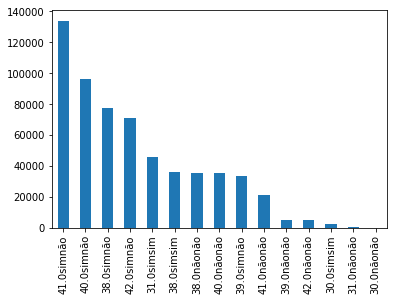

In [135]:
%matplotlib inline
df['Categoria'].value_counts().plot.bar()

In [ ]:
# importa bibliotecas

In [136]:
from sklearn.model_selection import train_test_split
##from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import sklearn

In [ ]:
# Função para avaliação dos modelos

In [137]:
def avalia_modelo(clf, X, y):
    resultados = sklearn.model_selection.cross_val_predict(clf, X, y, cv=5)
    # print( pd.crosstab(y, resultados, rownames=['Real'], colnames=['Predito'], margins=True))
    return np.mean(sklearn.model_selection.cross_val_score(clf, X, y, cv=5))

In [138]:
# Obtem lista de fornecedores com mais de 10000 itens
fornecedores = df['Remetente'].value_counts()
mask = fornecedores > 10000
fornecedores = list(fornecedores[mask].index)

In [139]:
len( fornecedores )

16

In [ ]:
# Cria função para retirar as palavras indesejadas e separadas manualmente

In [144]:
def limpaTexto2( entrada ):
    global stopwords
    entrada = str(entrada)
    entrada = entrada.split(" ")
    saida = ""
    for item in entrada:
        if item.lower() not in stopwords:
            saida = saida + item + " "
    return saida

In [145]:
df_resultado     = [ [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] ]
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )
df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )

In [146]:
len( df_resultado )

27

In [147]:
fornecedores

['MARTINS',
 'MAXIMUS, GARRA DB',
 'MUNDIAL',
 'NOVA AMAZONAS',
 'CONDOR',
 'DVA',
 'PAXAS',
 'AMERICA',
 'WL',
 'REDE BRASIL',
 'ITATIAIA',
 'MONTE MAR',
 'CARTEFIX',
 'MRC',
 'OBJETIVA',
 'DAMASCO']

In [ ]:
# calcula a precisão dos dados

In [148]:
df_completo = df.copy()

In [149]:
# cria o df de resultados
colunas = [ 'Remetente','registros1','precisao1','registros2','precisao2','registros3','precisao3','registros4','precisao4' ]
#df_resultado = [] #pd.DataFrame(columns = colunas)

for fonteDados in range(0,2):
    # fonteDados = 0 --> dados com as palavras separadas manualmente
    # fonteDados = 1 --> dados sem as palavras separadas manualmente
    
    linha  = 0
    coluna = 0

    # retira as palavras separadas manualmente
    if fonteDados == 1:
        print( )
        print('Sem palavras selecionadas manualemnte.')
        print()
        
        # Lê o arquivo de paravras indesejadas 
        df_palavras_a_eliminar = pd.read_csv('ETL_base_lista_palavras_a_retirar_minusculas.csv', sep=";")
        from nltk.corpus import stopwords
        stopwords = set( stopwords.words('portuguese') + list( df_palavras_a_eliminar['palavra'] ) )

        # retira as palavras indesejadas do df
        novadescricao = map( limpaTexto2, df['NovaDescricao'] ) 
        df.insert( loc = 2, column = "NovaDescricao2", value = list(novadescricao))#, allow_duplicates = False)
        del novadescricao 
        del df['NovaDescricao']
        df.columns = ['Remetente', 'NovaDescricao', 'Categoria']  
        
        linha  = 0
        coluna = 4
        
    # Cria um Pipeline - Classificador Composto
    # vectorizer => transformer => classifier 
    text_clf = Pipeline([('counts' , CountVectorizer() ),
                       #  ('tfidf', TfidfTransformer()),
                         ('classifier'  , MultinomialNB()   ),
                        ])
    
    # registra resultados
    df_resultado[linha][          0] = 'Todos'
    df_resultado[linha][ coluna + 1] = df.shape[0]
    df_resultado[linha][ coluna + 2] = avalia_modelo(text_clf, df['NovaDescricao'], df['Categoria'])
    
    print(linha,' : ',coluna+1)
    print( df_resultado[linha][          0] )
    print( df_resultado[linha][ coluna + 1] )
    print( df_resultado[linha][ coluna + 2] )
    print()
    
    # Cria um Pipeline - Classificador Composto
    # vectorizer => transformer => classifier 
    text_clf = Pipeline([('counts' , CountVectorizer() ),
                         ('tfidf', TfidfTransformer()),
                         ('classifier'  , MultinomialNB()   ),
                        ])
    
    # registra resultados
    df_resultado[linha][ coluna + 3] = df.shape[0]
    df_resultado[linha][ coluna + 4] = avalia_modelo(text_clf, df['NovaDescricao'], df['Categoria'])    
    
    print(linha,' : ',coluna+3)
    print( df_resultado[linha][          0] )
    print( df_resultado[linha][ coluna + 3] )
    print( df_resultado[linha][ coluna + 4] )
    print()
    
    # calcula precisão para fornecedores
    for fornecedor in fornecedores:
        
        linha += 1
        
        # obtem dados do fornecedor
        mask = df["Remetente"] == fornecedor
        dados_fornecedor = df[ mask ]
   

        # Cria um Pipeline - Classificador Composto
        # vectorizer => transformer => classifier 
        text_clf = Pipeline([('counts' , CountVectorizer() ),
                           #  ('tfidf', TfidfTransformer()),
                             ('classifier'  , MultinomialNB()   ),
                            ])

        # registra resultados
        df_resultado[linha][          0] = fornecedor
        df_resultado[linha][ coluna + 1] = dados_fornecedor.shape[0]
        df_resultado[linha][ coluna + 2] = avalia_modelo(text_clf, dados_fornecedor['NovaDescricao'], 
                                                                   dados_fornecedor['Categoria'])
        print(linha,' : ',coluna+1)
        print( df_resultado[linha][          0] )
        print( df_resultado[linha][ coluna + 1] )
        print( df_resultado[linha][ coluna + 2] )
        print()
    
        # Cria um Pipeline - Classificador Composto
        # vectorizer => transformer => classifier 
        text_clf = Pipeline([('counts' , CountVectorizer() ),
                             ('tfidf', TfidfTransformer()),
                             ('classifier'  , MultinomialNB()   ),
                            ])

        # registra resultados
        df_resultado[linha][ coluna + 3] = dados_fornecedor.shape[0]
        df_resultado[linha][ coluna + 4] = avalia_modelo(text_clf, dados_fornecedor['NovaDescricao'], 
                                                                   dados_fornecedor['Categoria'])         
        print(linha,' : ',coluna+3)
        print( df_resultado[linha][          0] )
        print( df_resultado[linha][ coluna + 3] )
        print( df_resultado[linha][ coluna + 4] )
        print()
    
    
    

0  :  1
Todos
598061
0.7698165305839713

0  :  3
Todos
598061
0.776404008646389



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


1  :  1
MARTINS
37298
0.8410062148738042



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


1  :  3
MARTINS
37298
0.8163129186233069



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


2  :  1
MAXIMUS, GARRA DB
27479
0.7212926143450435



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


2  :  3
MAXIMUS, GARRA DB
27479
0.7038221842394953



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


3  :  1
MUNDIAL
23979
0.8405488908743803



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


3  :  3
MUNDIAL
23979
0.8570912747461005



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


4  :  1
NOVA AMAZONAS
19076
0.851228874999206



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


4  :  3
NOVA AMAZONAS
19076
0.84756336997922



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


5  :  1
CONDOR
14277
0.8771588651805592



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


5  :  3
CONDOR
14277
0.8619628958070763



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


6  :  1
DVA
13932
0.7719358141220478



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


6  :  3
DVA
13932
0.7616697649070812

7  :  1
PAXAS
12890
0.9427456100536613

7  :  3
PAXAS
12890
0.960123572297445



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


8  :  1
AMERICA
12232
0.6992086383840489



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


8  :  3
AMERICA
12232
0.677365841980102



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


9  :  1
WL
12200
0.9024789536834519



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


9  :  3
WL
12200
0.9035537351152936

10  :  1
REDE BRASIL
11872
0.7478091984654092

10  :  3
REDE BRASIL
11872
0.7316459395176069



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


11  :  1
ITATIAIA
11600
0.8825316684425021



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


11  :  3
ITATIAIA
11600
0.8779332725504154

12  :  1
MONTE MAR
11395
0.7246137542675957

12  :  3
MONTE MAR
11395
0.7132592694650821



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


13  :  1
CARTEFIX
10958
0.839096804603701



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


13  :  3
CARTEFIX
10958
0.8745699413293234

14  :  1
MRC
10863
0.6944047293664483

14  :  3
MRC
10863
0.7027350627829068



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


15  :  1
OBJETIVA
10604
0.902043313701731



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


15  :  3
OBJETIVA
10604
0.9078791958958268



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


16  :  1
DAMASCO
10152
0.9235632059298082



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


16  :  3
DAMASCO
10152
0.9110511668526632


Sem palavras selecionadas manualemnte.

0  :  5
Todos
598061
0.7697947930332925

0  :  7
Todos
598061
0.7764123707310207



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


1  :  5
MARTINS
37298
0.8411134103686869



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


1  :  7
MARTINS
37298
0.8162593100308684



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


2  :  5
MAXIMUS, GARRA DB
27479
0.7212926143450435



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


2  :  7
MAXIMUS, GARRA DB
27479
0.7038221842394953



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


3  :  5
MUNDIAL
23979
0.8405488908743803



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


3  :  7
MUNDIAL
23979
0.8570912747461005



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


4  :  5
NOVA AMAZONAS
19076
0.8517534379770367



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


4  :  7
NOVA AMAZONAS
19076
0.8478254384622403



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


5  :  5
CONDOR
14277
0.8765279012460766



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


5  :  7
CONDOR
14277
0.862032506992982



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


6  :  5
DVA
13932
0.7719358141220478



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


6  :  7
DVA
13932
0.7616697649070812

7  :  5
PAXAS
12890
0.9427456100536613

7  :  7
PAXAS
12890
0.960123572297445



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


8  :  5
AMERICA
12232
0.6992086383840489



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


8  :  7
AMERICA
12232
0.677365841980102



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


9  :  5
WL
12200
0.9026428546954339



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


9  :  7
WL
12200
0.9034718350333932

10  :  5
REDE BRASIL
11872
0.7478091984654092

10  :  7
REDE BRASIL
11872
0.7316459395176069



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


11  :  5
ITATIAIA
11600
0.8825316684425021



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


11  :  7
ITATIAIA
11600
0.878364679255974

12  :  5
MONTE MAR
11395
0.7246137542675957

12  :  7
MONTE MAR
11395
0.7132592694650821



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


13  :  5
CARTEFIX
10958
0.839096804603701



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


13  :  7
CARTEFIX
10958
0.8745699413293234

14  :  5
MRC
10863
0.6944047293664483

14  :  7
MRC
10863
0.7027350627829068



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


15  :  5
OBJETIVA
10604
0.902043313701731



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


15  :  7
OBJETIVA
10604
0.9078791958958268



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


16  :  5
DAMASCO
10152
0.9238595490105925



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


16  :  7
DAMASCO
10152
0.911642639804526



In [150]:
df_resultado

[['Todos',
  598061,
  0.7698165305839713,
  598061,
  0.776404008646389,
  598061,
  0.7697947930332925,
  598061,
  0.7764123707310207],
 ['MARTINS',
  37298,
  0.8410062148738042,
  37298,
  0.8163129186233069,
  37298,
  0.8411134103686869,
  37298,
  0.8162593100308684],
 ['MAXIMUS, GARRA DB',
  27479,
  0.7212926143450435,
  27479,
  0.7038221842394953,
  27479,
  0.7212926143450435,
  27479,
  0.7038221842394953],
 ['MUNDIAL',
  23979,
  0.8405488908743803,
  23979,
  0.8570912747461005,
  23979,
  0.8405488908743803,
  23979,
  0.8570912747461005],
 ['NOVA AMAZONAS',
  19076,
  0.851228874999206,
  19076,
  0.84756336997922,
  19076,
  0.8517534379770367,
  19076,
  0.8478254384622403],
 ['CONDOR',
  14277,
  0.8771588651805592,
  14277,
  0.8619628958070763,
  14277,
  0.8765279012460766,
  14277,
  0.862032506992982],
 ['DVA',
  13932,
  0.7719358141220478,
  13932,
  0.7616697649070812,
  13932,
  0.7719358141220478,
  13932,
  0.7616697649070812],
 ['PAXAS',
  12890,
  0.94

In [154]:
colunas = [ 'Remetente','registros1','precisao1','registros2','precisao2','registros3','precisao3','registros4','precisao4' ]
df_resposta = pd.DataFrame(data = df_resultado, columns = colunas)


In [156]:
df_resposta.to_csv("Resultados_acima_10000.csv", index = False, encoding = "utf-8", sep = ';')